# STORMS PREDICTION MODEL

The following data analysis have the goal on creating a model which is able to predict the number of tropical storms and hurricanes by season in the Atlantic Ocean (The Atlantic Hurricane seasons runs from June 1st to November 30th every year). 



### Load python packages

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backend_bases import MouseButton
from matplotlib import dates as mdates
import plotly.express as px

In [9]:
import missingno as msno
from pandas.api.types import CategoricalDtype
from thefuzz import fuzz
from thefuzz import process
from datetime import datetime
import plotly.graph_objects as go

pd.options.display.float_format = "{:,.2f}".format

In [10]:

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose


## Loading previously clean Storm dataframe

In [12]:
storms_uniq = pd.read_csv('../data/storms_uniq.csv', index_col='date')

In [13]:
storms_uniq.index = pd.to_datetime(storms_uniq.index)
storms_uniq.head(5)

year  month  day  hour   lat   long               status  \
date                                                                   
1975-06-28  1975      6   28    18 34.00 -77.00  tropical depression   
1975-07-26  1975      7   26     0 31.00 -75.00  tropical depression   
1975-09-01  1975      9    1     0 25.10 -98.30  tropical depression   
1975-09-24  1975      9   24     0 35.50 -84.30  tropical depression   
1975-09-25  1975      9   25     0 23.80 -57.20  tropical depression   

            category  wind  pressure  tropicalstorm_force_diameter  \
date                                                                 
1975-06-28      0.00    30      1006                        125.47   
1975-07-26      0.00    30      1005                        125.47   
1975-09-01      0.00    30      1000                        125.47   
1975-09-24      0.00    30       999                        125.47   
1975-09-25      0.00    30      1005                        125.47   

            hurricane_force_diameter  
date                                  
1975-06-28                      4.56  
1975-07-26                      4.56  
1975-09-01                      4.56  
1975-09-24                      4.56  
1975-09-25                      4.56

In [14]:
storms_uniq.dtypes

year                              int64
month                             int64
day                               int64
hour                              int64
lat                             float64
long                            float64
status                           object
category                        float64
wind                              int64
pressure                          int64
tropicalstorm_force_diameter    float64
hurricane_force_diameter        float64
dtype: object

In [15]:
storms_uniq.status.value_counts()

status
tropical depression    248
tropical storm         213
hurricane              173
Name: count, dtype: int64

In [16]:
status_type_dict = {"tropical depression":1,
                    "tropical storm":2,
                    "hurricane":3}

cat_type = CategoricalDtype(categories=["tropical depression", "tropical storm", "hurricane"], ordered=True)

storms_uniq.status = storms_uniq.status.astype(cat_type)
storms_uniq['status_code'] = storms_uniq.status.map(status_type_dict)

storms_uniq['status_code']


date
1975-06-28    1
1975-07-26    1
1975-09-01    1
1975-09-24    1
1975-09-25    1
             ..
2021-07-02    3
2021-08-21    3
2021-09-06    3
2021-08-29    3
2021-09-26    3
Name: status_code, Length: 634, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [17]:
storms_uniq.sort_index(inplace=True)

In [18]:
categorical_features = ['status']
storms_uniq = pd.get_dummies(storms_uniq, columns = categorical_features,dtype=float)
print('The data have ', storms_uniq.shape[0], ' rows and ', storms_uniq.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(storms_uniq.columns)))



The data have  634  rows and  15  columns

column names: 

year
month
day
hour
lat
long
category
wind
pressure
tropicalstorm_force_diameter
hurricane_force_diameter
status_code
status_tropical depression
status_tropical storm
status_hurricane


In [19]:
storms_uniq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 634 entries, 1975-06-28 to 2021-11-06
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   year                          634 non-null    int64   
 1   month                         634 non-null    int64   
 2   day                           634 non-null    int64   
 3   hour                          634 non-null    int64   
 4   lat                           634 non-null    float64 
 5   long                          634 non-null    float64 
 6   category                      634 non-null    float64 
 7   wind                          634 non-null    int64   
 8   pressure                      634 non-null    int64   
 9   tropicalstorm_force_diameter  634 non-null    float64 
 10  hurricane_force_diameter      634 non-null    float64 
 11  status_code                   634 non-null    category
 12  status_tropical depression    6

In [20]:
#storms_uniq.sort_values(by='date', inplace=True, ascending=True)

storms_uniq['status_hurricane_cumm'] = storms_uniq['status_hurricane'].cumsum()
storms_uniq['status_tropical depression_cumm'] = storms_uniq['status_tropical depression'].cumsum()
storms_uniq['status_tropical storm_cumm'] = storms_uniq['status_tropical storm'].cumsum()

storms_uniq['Total_Storms'] = storms_uniq['status_hurricane'] + storms_uniq['status_tropical depression'] + storms_uniq['status_tropical storm']

#storms_uniq.set_index('date', inplace=True, drop=True)



In [21]:
storms_uniq.head()

year  month  day  hour   lat   long  category  wind  pressure  \
date                                                                        
1975-06-28  1975      6   28    18 34.00 -77.00      0.00    30      1006   
1975-07-02  1975      7    2    18 37.30 -64.10      0.00    60       986   
1975-07-26  1975      7   26     0 31.00 -75.00      0.00    30      1005   
1975-07-27  1975      7   27     0 35.00 -71.00      0.00    60       992   
1975-07-28  1975      7   28     0 39.30 -67.20      1.00    75       980   

            tropicalstorm_force_diameter  hurricane_force_diameter  \
date                                                                 
1975-06-28                        125.47                      4.56   
1975-07-02                        125.47                      4.56   
1975-07-26                        125.47                      4.56   
1975-07-27                        125.47                      4.56   
1975-07-28                        260.79                     65.75   

           status_code  status_tropical depression  status_tropical storm  \
date                                                                        
1975-06-28           1                        1.00                   0.00   
1975-07-02           2                        0.00                   1.00   
1975-07-26           1                        1.00                   0.00   
1975-07-27           2                        0.00                   1.00   
1975-07-28           3                        0.00                   0.00   

            status_hurricane  status_hurricane_cumm  \
date                                                  
1975-06-28              0.00                   0.00   
1975-07-02              0.00                   0.00   
1975-07-26              0.00                   0.00   
1975-07-27              0.00                   0.00   
1975-07-28              1.00                   1.00   

            status_tropical depression_cumm  status_tropical storm_cumm  \
date                                                                      
1975-06-28                             1.00                        0.00   
1975-07-02                             1.00                        1.00   
1975-07-26                             2.00                        1.00   
1975-07-27                             2.00                        2.00   
1975-07-28                             2.00                        2.00   

            Total_Storms  
date                      
1975-06-28          1.00  
1975-07-02          1.00  
1975-07-26          1.00  
1975-07-27          1.00  
1975-07-28          1.00

In [22]:
storms_uniq['status_tropical storm_cumm'].tail(5)

date
2021-09-24   211.00
2021-09-26   211.00
2021-10-01   212.00
2021-10-04   212.00
2021-11-06   213.00
Name: status_tropical storm_cumm, dtype: float64

In [23]:
class_counts = storms_uniq[['status_hurricane','status_tropical depression','status_tropical storm']].value_counts().reset_index()
class_counts

status_hurricane  status_tropical depression  status_tropical storm  count
0              0.00                        1.00                   0.00    248
1              0.00                        0.00                   1.00    213
2              1.00                        0.00                   0.00    173

## Visualization of Storm dataframe

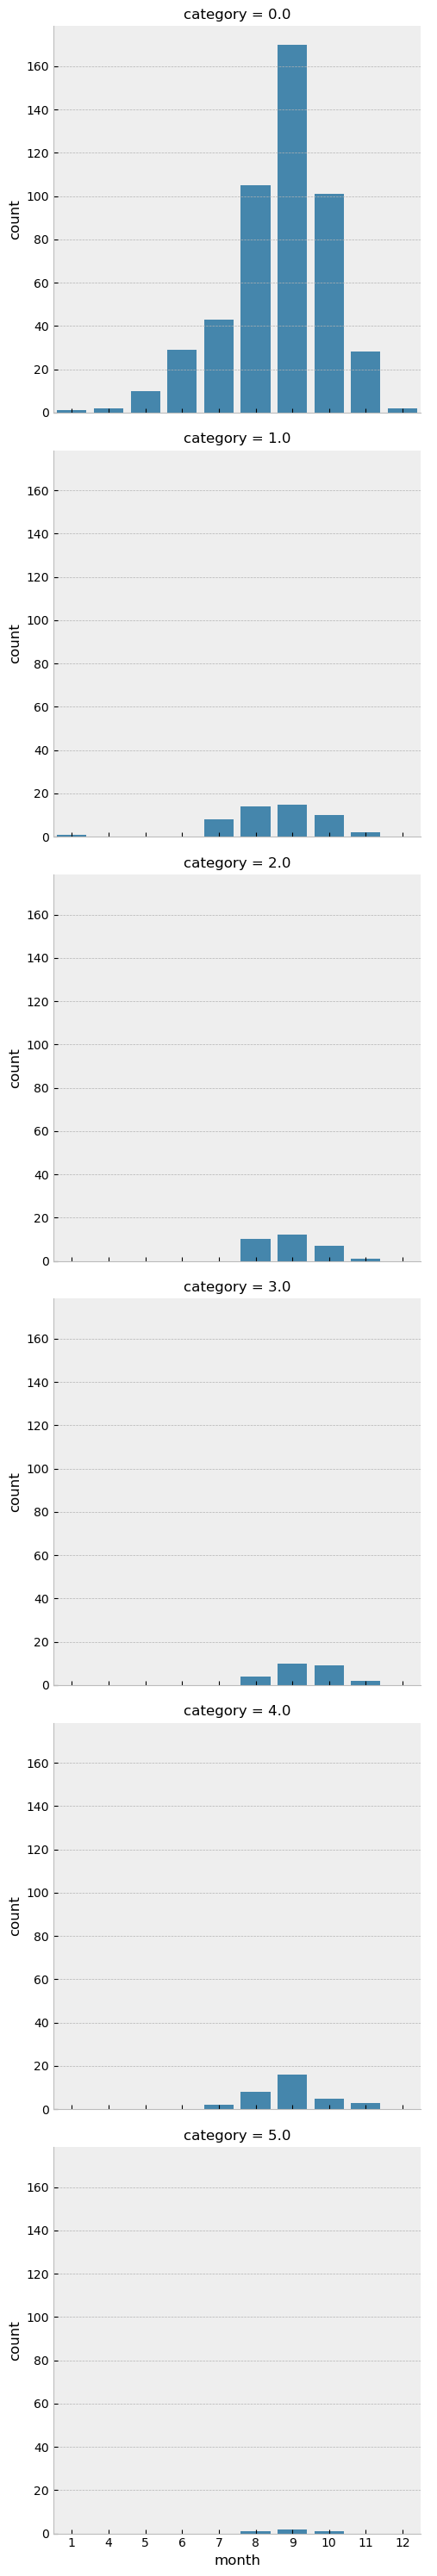

In [25]:
plt.style.use('bmh')

ax = sns.catplot(x='month',
            data=storms_uniq,
            row='category',
            kind='count')   
    

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_28455/1472056686.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot_y = storms_uniq[['status_code','year','Total_Storms']].groupby(['status_code','year']).sum().reset_index()


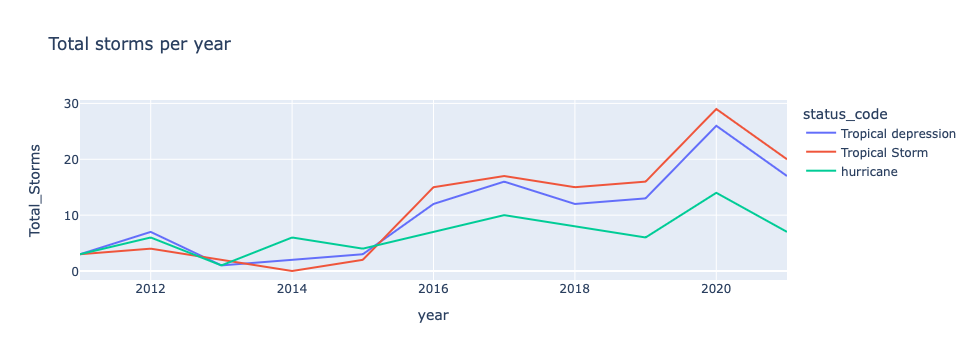

In [26]:

year_order = [2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

df_plot_y = storms_uniq[['status_code','year','Total_Storms']].groupby(['status_code','year']).sum().reset_index()

df_plot_y = df_plot_y.set_index('year').loc[year_order].reset_index()

fig = px.line(df_plot_y, x='year', y='Total_Storms', title= 'Total storms per year', color='status_code', line_group='status_code')

newnames = {'1':'Tropical depression', '2': 'Tropical Storm', '3': 'hurricane'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.show()



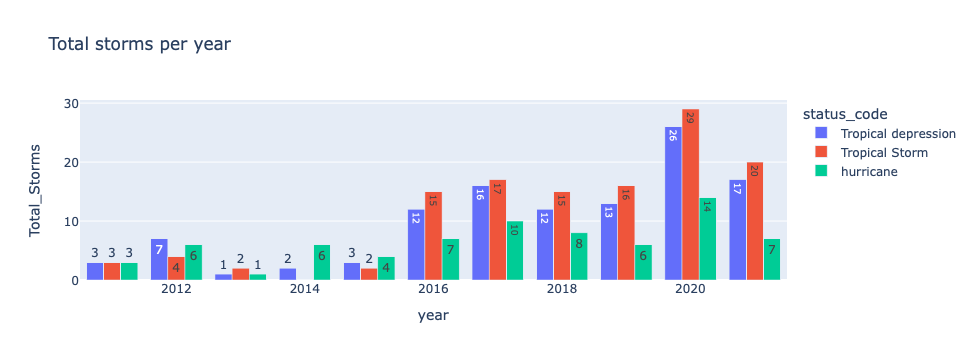

In [27]:

fig = px.bar(df_plot_y, x='year', y='Total_Storms', title= 'Total storms per year', barmode='group',color='status_code',text_auto=True)
newnames = {'1':'Tropical depression', '2': 'Tropical Storm', '3': 'hurricane'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.show()


/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_28455/4171036085.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



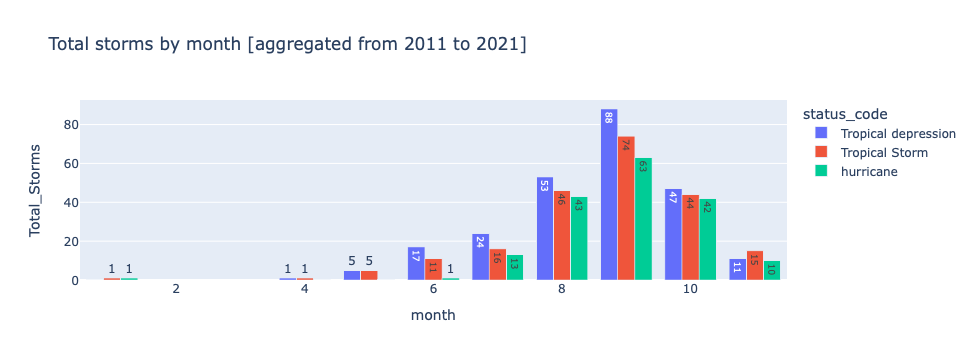

In [28]:
#month_order = ['January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'November', 'December']
month_order = [1,4,5,6,7,8,9,10,11]

df_plot_m = storms_uniq[['status_code','month','Total_Storms']].groupby(['status_code','month']).sum().reset_index()

df_plot_m = df_plot_m.set_index('month').loc[month_order].reset_index()

fig = px.bar(df_plot_m, x='month', y='Total_Storms', title= 'Total storms by month')

fig = px.bar(df_plot_m, x='month', y='Total_Storms', title= 'Total storms by month [aggregated from 2011 to 2021]', barmode='group',color='status_code',text_auto=True)

newnames = {'1':'Tropical depression', '2': 'Tropical Storm', '3': 'hurricane'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.show()


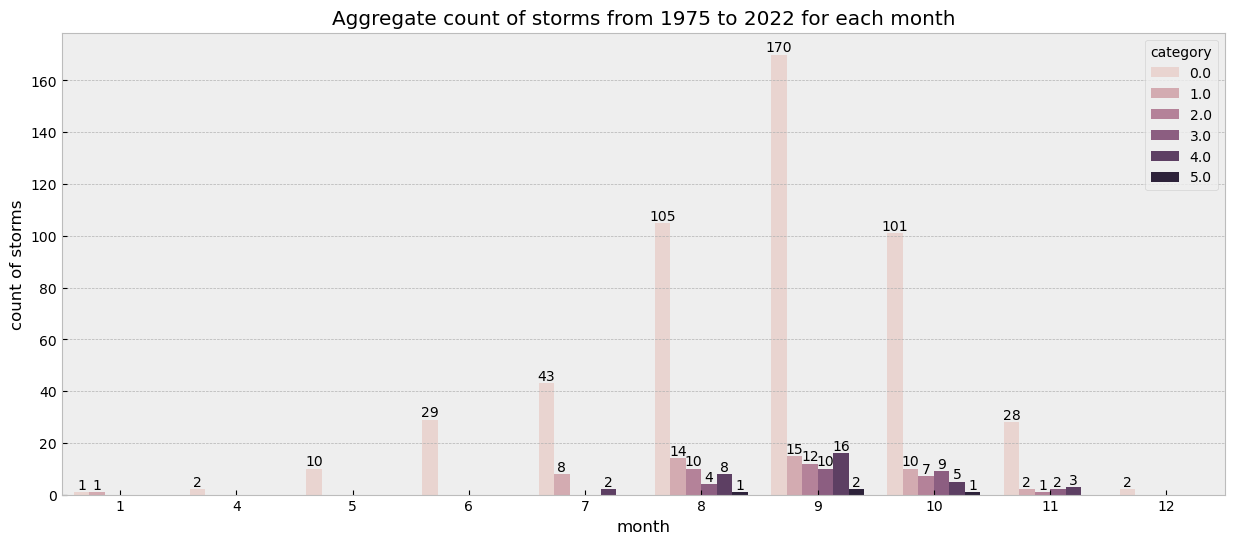

In [29]:
## Figure showing the aggregate counts of storms per month from 1975 to 2022.

fig, ax_m = plt.subplots(figsize=(15,6))

ax_m = sns.countplot(data=storms_uniq, x = 'month', hue='category')

for container in ax_m.containers:
    ax_m.bar_label(container)

ax_m.set_xlabel('month')
ax_m.set_ylabel('count of storms')
ax_m.set_title('Aggregate count of storms from 1975 to 2022 for each month')

plt.show()

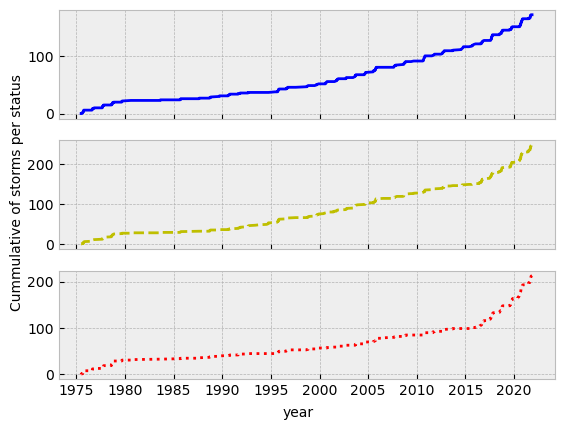

In [30]:
fig, ax = plt.subplots(3, 1, sharex=True)


ax[0].plot(storms_uniq.index, storms_uniq['status_hurricane_cumm'], color = 'b')
ax[1].plot(storms_uniq.index, storms_uniq['status_tropical depression_cumm'], color = 'y', linestyle = '--')
ax[2].plot(storms_uniq.index, storms_uniq['status_tropical storm_cumm'], color = 'r', linestyle = ':')

fig.text(0.5, 0.04, 'year', ha='center', va='center')
fig.text(0.06, 0.5, 'Cummulative of storms per status', ha='center', va='center', rotation='vertical')

plt.show()

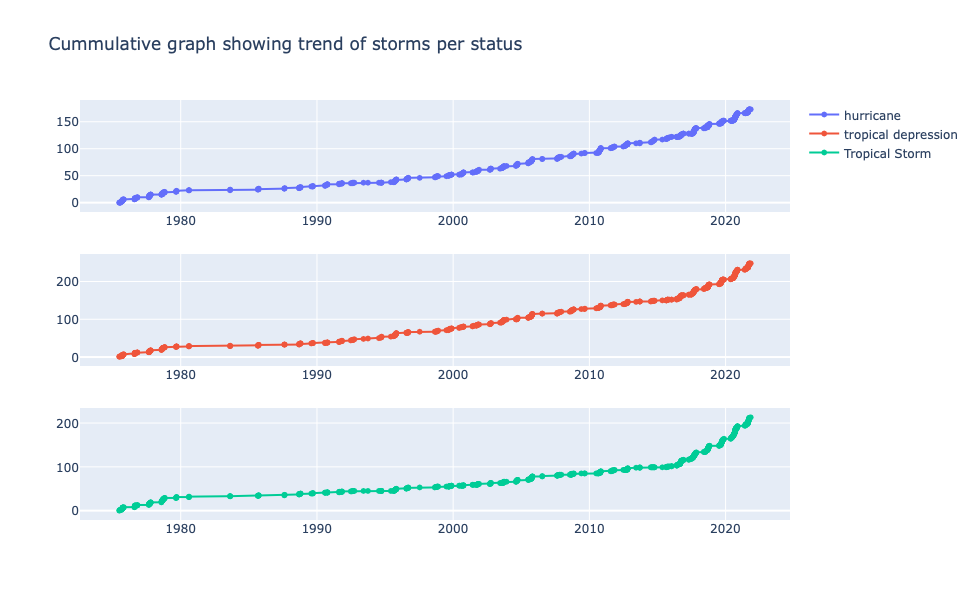

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

year_order = [2016,2017,2018,2019,2020,2021]

#storms_uniq['status_hurricane'] + storms_uniq['status_tropical depression'] + storms_uniq['status_tropical storm']
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=storms_uniq.index, y=storms_uniq['status_hurricane_cumm'],mode='lines+markers', name='hurricane'), row=1, col=1)
fig.add_trace(go.Scatter(x=storms_uniq.index, y=storms_uniq['status_tropical depression_cumm'], mode='lines+markers', name='tropical depression'), row=2, col=1)
fig.add_trace(go.Scatter(x=storms_uniq.index, y=storms_uniq['status_tropical storm_cumm'], mode='lines+markers', name='Tropical Storm'), row=3, col=1)


fig.update_layout(height=600, width=800, title_text="Cummulative graph showing trend of storms per status")
fig.show()


In [32]:
storms_uniq.head(2)

year  month  day  hour   lat   long  category  wind  pressure  \
date                                                                        
1975-06-28  1975      6   28    18 34.00 -77.00      0.00    30      1006   
1975-07-02  1975      7    2    18 37.30 -64.10      0.00    60       986   

            tropicalstorm_force_diameter  hurricane_force_diameter  \
date                                                                 
1975-06-28                        125.47                      4.56   
1975-07-02                        125.47                      4.56   

           status_code  status_tropical depression  status_tropical storm  \
date                                                                        
1975-06-28           1                        1.00                   0.00   
1975-07-02           2                        0.00                   1.00   

            status_hurricane  status_hurricane_cumm  \
date                                                  
1975-06-28              0.00                   0.00   
1975-07-02              0.00                   0.00   

            status_tropical depression_cumm  status_tropical storm_cumm  \
date                                                                      
1975-06-28                             1.00                        0.00   
1975-07-02                             1.00                        1.00   

            Total_Storms  
date                      
1975-06-28          1.00  
1975-07-02          1.00

## Resample Storm dataframe

### First using "year" periods

In [35]:
storms_uniq_year = storms_uniq.resample(rule='Y').last()

In [36]:
storms_qty = storms_uniq[['status_hurricane','status_tropical depression','status_tropical storm']]


In [37]:
storms_qty_year = storms_qty.resample(rule='Y').sum()

In [38]:
storms_qty_year.tail(5)

status_hurricane  status_tropical depression  \
date                                                       
2017-12-31             10.00                       16.00   
2018-12-31              8.00                       12.00   
2019-12-31              6.00                       13.00   
2020-12-31             14.00                       26.00   
2021-12-31              7.00                       17.00   

            status_tropical storm  
date                               
2017-12-31                  17.00  
2018-12-31                  15.00  
2019-12-31                  16.00  
2020-12-31                  29.00  
2021-12-31                  20.00

<Axes: xlabel='date'>

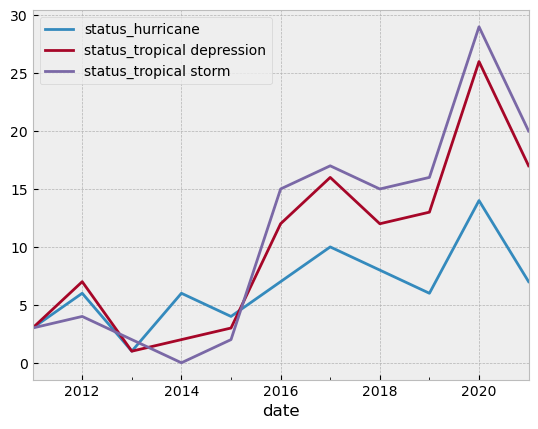

In [97]:
storms_qty_year.loc[storms_qty_year.index > '2011'].plot()

In [99]:
storms_qty_year_depression = storms_qty_year['status_tropical depression']
storms_qty_year_tropical = storms_qty_year['status_tropical storm']
storms_qty_year_hurricane = storms_qty_year['status_hurricane']

### Searching for best lag for timeline differencing and identifying seasonality.

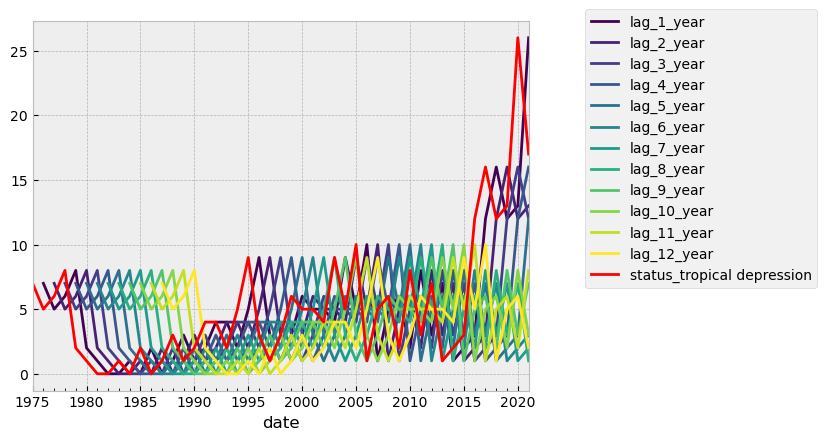

In [102]:
# These are the "time lags"
shifts = np.arange(1, 13).astype(int)



# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_year".format(day_shift): storms_qty_year_depression.shift(day_shift) 
                for day_shift in shifts}

# Convert into a DataFrame for subsequent use
storms_qty_year_depression_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = storms_qty_year_depression_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
storms_qty_year_depression.iloc[:100].plot(color='r', lw=2)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [104]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax
X = storms_qty_year_depression_shifted.fillna(np.nanmedian(storms_qty_year_depression_shifted))
y = storms_qty_year_depression.fillna(np.nanmedian(storms_qty_year_depression))

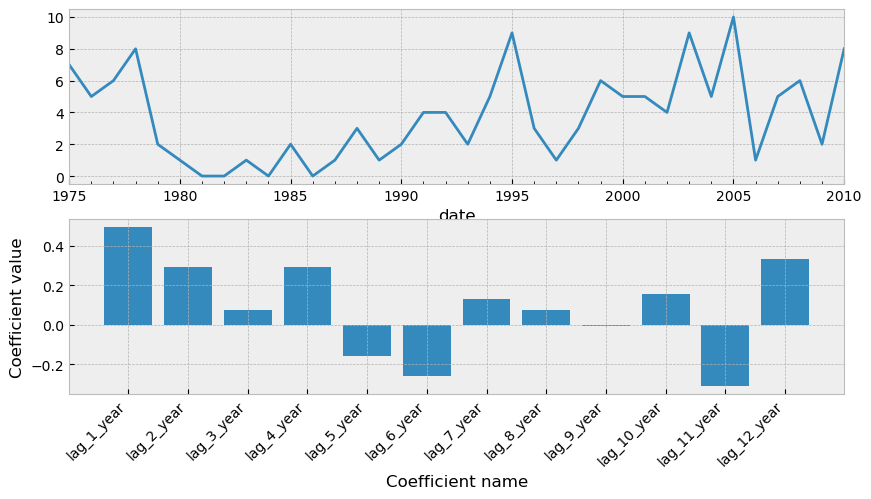

In [112]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X, y)

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, storms_qty_year_depression_shifted.columns, ax=axs[1])
plt.show()

**The above graphs shows a best coeficient when Lag equals 1 (or 1 year/12 months)**

## Analysing if timelines are stationary

In [116]:
from statsmodels.tsa.stattools import adfuller
result_depression = adfuller(storms_qty_year['status_tropical depression'])
result_tropical = adfuller(storms_qty_year['status_tropical storm'])
result_hurricane = adfuller(storms_qty_year['status_hurricane'])

print(f'The adfuller test for: \nTropical depression time series: {result_depression}\n\n'
f'Tropical storm time series: {result_tropical} \n\nHurricane time series:  {result_hurricane}')

The adfuller test for: 
Tropical depression time series: (-0.627694555379914, 0.864600604842141, 1, 45, {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}, 208.3384737620214)

Tropical storm time series: (0.42838133717204, 0.9825258315913745, 2, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 205.1416181887999) 

Hurricane time series:  (0.02814511772210794, 0.9607986926851251, 4, 42, {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}, 179.0328011565104)


**The above results shows that all 3 timelines are not stationary (P value > 0.05 on Adfuller test)**

<Axes: title={'center': 'Total storm per year'}, xlabel='date', ylabel='Hurricane'>

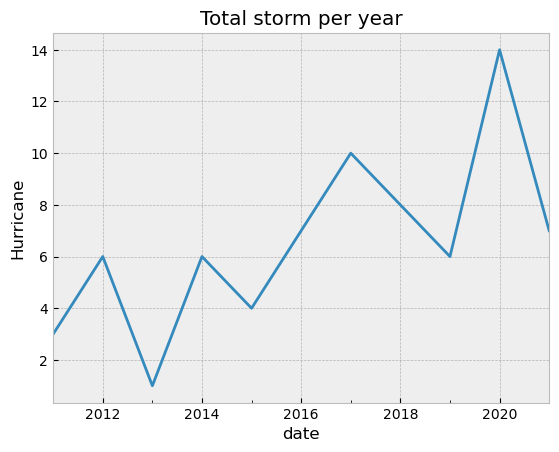

In [118]:
storms_qty_year.loc[storms_qty_year.index>'2011','status_hurricane'].plot(ylabel='Hurricane',
                                                                               title='Total storm per year')



<Axes: title={'center': 'Total storm per year'}, xlabel='date', ylabel='Tropical Depression'>

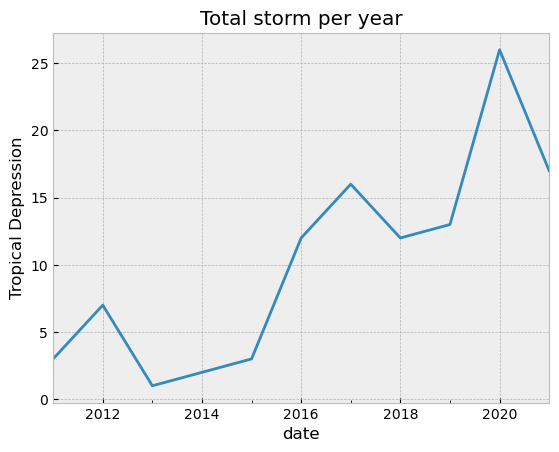

In [119]:
storms_qty_year.loc[storms_qty_year.index>'2011','status_tropical depression'].plot(ylabel='Tropical Depression',
                                                                               title='Total storm per year')

<Axes: title={'center': 'Total storm per year'}, xlabel='date', ylabel='Tropical Storm'>

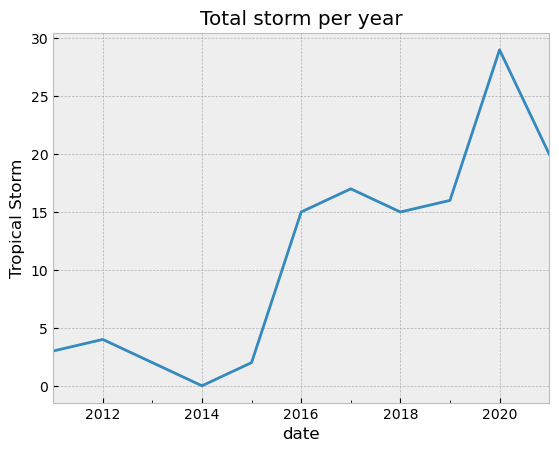

In [120]:
storms_qty_year.loc[storms_qty_year.index>'2011','status_tropical storm'].plot(ylabel='Tropical Storm',
                                                                               title='Total storm per year')

**Taking first difference on every timeline to make then "Stationary"**

In [122]:
depression_diff = storms_qty_year['status_tropical depression'].diff().dropna()
result_depression_diff = adfuller(depression_diff)
print(f'Adfuller test results of 1st difference for Tropical depression: {result_depression_diff}')

Adfuller test results of 1st difference for Tropical depression: (-10.127681235133496, 9.090300233725712e-18, 0, 45, {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}, 201.83322505001132)


In [123]:
tropical_diff = storms_qty_year['status_tropical storm'].diff().dropna()
result_tropical_diff = adfuller(tropical_diff)
print(f'Adfuller test results of 1st difference for Tropical depression: {result_tropical_diff}')


Adfuller test results of 1st difference for Tropical depression: (-6.397155055958004, 2.0374463425819582e-08, 1, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 198.8739655944987)


In [124]:
hurricane_diff = storms_qty_year['status_hurricane'].diff().dropna()
result_hurricane_diff = adfuller(hurricane_diff)
print(f'Adfuller test results of 1st difference for Hurricane: {result_hurricane_diff}')


Adfuller test results of 1st difference for Hurricane: (-4.626567729673552, 0.00011536274774458879, 3, 42, {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}, 173.4572006013081)


**Looking for Seasonality for every timeseries**

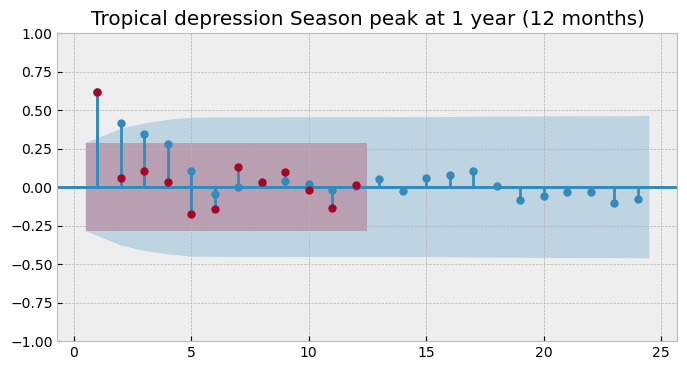

In [305]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(storms_qty_year['status_tropical depression'], ax=ax, lags=24, zero=False)
plt.title('Tropical depression Season peak at 1 year (12 months)')

plot_pacf(storms_qty_year['status_tropical depression'], ax=ax, lags=12, zero=False)
plt.title('Tropical depression Season peak at 1 year (12 months)')
plt.show()

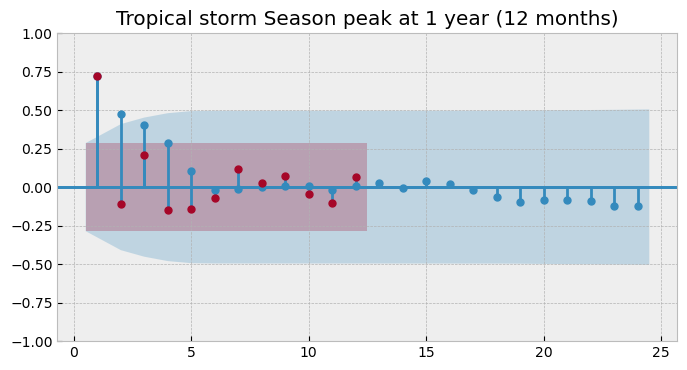

In [309]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(storms_qty_year['status_tropical storm'], ax=ax, lags=24, zero=False)
plt.title('Tropical storm Season peak at 1 year (12 months)')

plot_pacf(storms_qty_year['status_tropical storm'], ax=ax, lags=12, zero=False)
plt.title('Tropical storm Season peak at 1 year (12 months)')

plt.show()


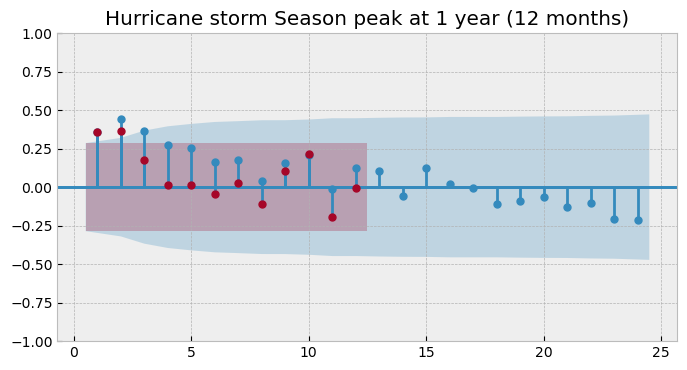

In [313]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(storms_qty_year['status_hurricane'], ax=ax, lags=24, zero=False)
plt.title('Hurricane storm Season peak at 1 year (12 months)')

plot_pacf(storms_qty_year['status_hurricane'], ax=ax, lags=12, zero=False)
plt.title('Hurricane storm Season peak at 1 year (12 months)')
plt.show()



# Exploring model parameters for timeline - resample per year

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=261.977, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=266.592, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=258.970, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=257.589, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=264.715, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=259.311, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=259.149, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=260.440, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=256.447, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=258.159, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=257.973, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=257.550, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=258.988, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.106 seconds
                               SARI

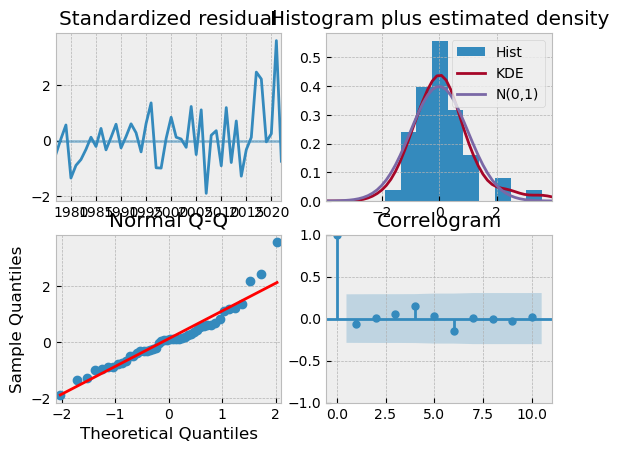

In [130]:
import pmdarima as pm

tropical_depression_2011 = storms_qty_year.loc[storms_qty_year.index>'2011','status_tropical depression']

tropical_depression_2011_diff = tropical_depression_2011.diff().dropna()

result_depression = pm.auto_arima(storms_qty_year_depression,
                          seasonal=False,
                          d=1, 
                          max_d=2, max_p=4, max_q=4, 
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True
                            )

print(result_depression.summary())

result_depression.plot_diagnostics()

plt.show();


## Creating model to predict Tropical Depression

In [132]:
from statsmodels.tsa.arima.model import ARIMA

model_depression = ARIMA(storms_qty_year_depression, order=(0,1,1))

result_depression = model_depression.fit()

print(result_depression.summary())

                                   SARIMAX Results                                    
Dep. Variable:     status_tropical depression   No. Observations:                   47
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -126.224
Date:                        Wed, 31 Jul 2024   AIC                            256.447
Time:                                19:34:48   BIC                            260.105
Sample:                            12-31-1975   HQIC                           257.817
                                 - 12-31-2021                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4637      0.145     -3.188      0.001      -0.749      -0.179
sigma2        14.0813      2.181      6.457      0.000       9.807 

In [133]:
prediction_depression = result_depression.get_prediction(start=-24)

mean_prediction_depression = prediction_depression.predicted_mean
#round(mean_forecast,0)

In [134]:
confidence_intervals = prediction_depression.conf_int()

lower_limits = confidence_intervals.loc[:,'lower status_tropical depression']
upper_limits = confidence_intervals.loc[:,'upper status_tropical depression']

In [162]:
def plot_forecast_prediction(original_series, predicted_mean_series, lower_limit, upper_limit):
    plt.figure()

    plt.plot(original_series.index, original_series, label='observed')

    plt.plot(predicted_mean_series.index, predicted_mean_series, color='r', label='forecast')

    plt.fill_between(lower_limit.index, lower_limit,
         upper_limit, color='pink')

    plt.xlabel('Date')
    plt.ylabel('Series')
    plt.legend()
    plt.show();

In [164]:
def plot_forecast_prediction_plotly(original_series, predicted_mean_series, lower_limit, upper_limit):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=original_series.index, y=original_series,
                    mode='lines',
                    name='observed'))
    fig.add_trace(go.Scatter(x=predicted_mean_series.index, y=predicted_mean_series,
                    mode='lines',
                    name='forecast'))
    
    fig.add_trace(go.Scatter(x=upper_limit.index, y=upper_limit,
                    line = dict(color='rgba(0,0,0,0)'),
                    mode='lines',
                    name='Upper Conf Int'))  

    fig.add_traces(go.Scatter(x=lower_limit.index, y = lower_limit,
                        line = dict(color='rgba(0,0,0,0)'),
                        fill='tonexty',
                        name='Lower Conf Int',
                        fillcolor = 'rgba(255,165,0,0.2)'))
    
    fig.update_layout(title='Timeline: observed vs predicted/forecasted values',
                   xaxis_title='Date',
                   yaxis_title='Storm quantity')
    
    
    fig.show();

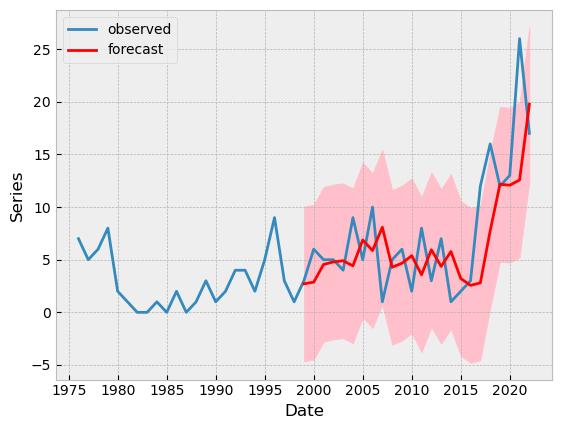

In [166]:
plot_forecast_prediction(storms_qty_year_depression, mean_prediction_depression,
                         lower_limits, upper_limits)

## Forecasting of Tropical depression 

In [169]:
depression_forecast_steps = result_depression.get_forecast(steps=3)

mean_forecast_depression = depression_forecast_steps.predicted_mean

confidence_interval_fc_depression = depression_forecast_steps.conf_int()

lower_limits_forecast = confidence_interval_fc_depression.loc[:,'lower status_tropical depression']
upper_limits_forecast = confidence_interval_fc_depression.loc[:,'upper status_tropical depression']



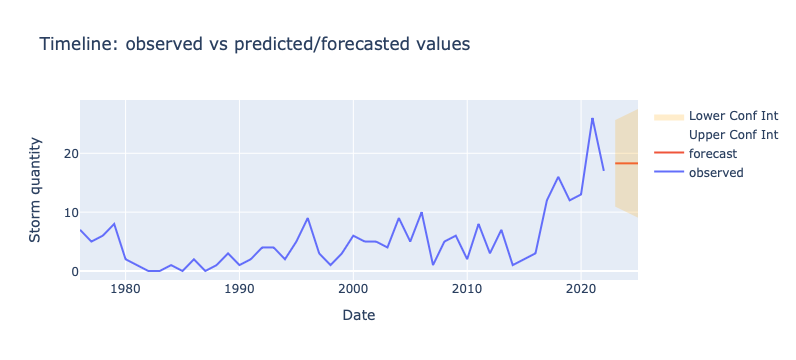

In [170]:
plot_forecast_prediction_plotly(storms_qty_year_depression, mean_forecast_depression,
                         lower_limits_forecast, upper_limits_forecast)

# Exploring model parameters for timeline - resample per month

In [172]:
storms_qty_month = storms_qty.resample(rule='M').sum()

In [173]:
storms_qty_month_depression = storms_qty_month['status_tropical depression']
storms_qty_month_tropical = storms_qty_month['status_tropical storm']
storms_qty_month_hurricane = storms_qty_month['status_hurricane']

In [253]:
from statsmodels.tsa.stattools import adfuller
result_depression_m = adfuller(storms_qty_month['status_tropical depression'])
result_tropical_m = adfuller(storms_qty_month['status_tropical storm'])
result_hurricane_m = adfuller(storms_qty_month['status_hurricane'])

print(f'The adfuller test for: \nTropical depression time series: {result_depression_m}\n\n'
f'Tropical storm time series: {result_tropical_m} \n\nHurricane time series:  {result_hurricane_m}')

The adfuller test for: 
Tropical depression time series: (-2.6342455877399718, 0.0861239179395511, 14, 543, {'1%': -3.442450336733213, '5%': -2.8668774460774498, '10%': -2.5696126760816553}, 1360.9555919745453)

Tropical storm time series: (-1.7074542085233497, 0.4272759947110912, 14, 543, {'1%': -3.442450336733213, '5%': -2.8668774460774498, '10%': -2.5696126760816553}, 1174.216539223083) 

Hurricane time series:  (-4.3367033373585775, 0.00038350701537642057, 14, 543, {'1%': -3.442450336733213, '5%': -2.8668774460774498, '10%': -2.5696126760816553}, 1080.6075902232194)


**The above results shows that the Depression and Tropical storms timelines are not stationary (P value > 0.05 on Adfuller test), and that the hurricane timeline is stationary (P value < 0.05 on Adfuller test**

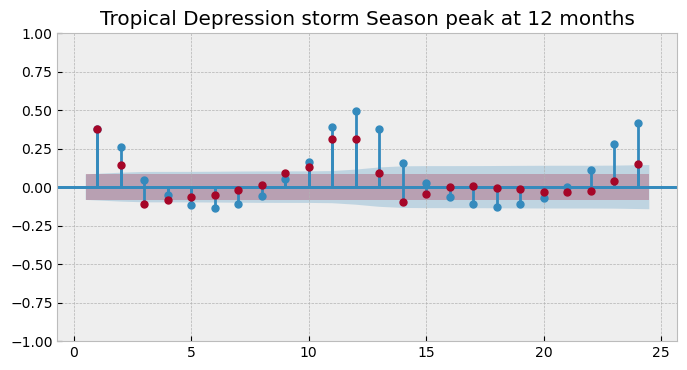

In [327]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(storms_qty_month['status_tropical depression'], ax=ax, lags=24, zero=False)
plt.title('Tropical storm Season peak at 12 months')

plot_pacf(storms_qty_month['status_tropical depression'], ax=ax, lags=24, zero=False)
plt.title('Tropical Depression storm Season peak at 12 months')

plt.show()

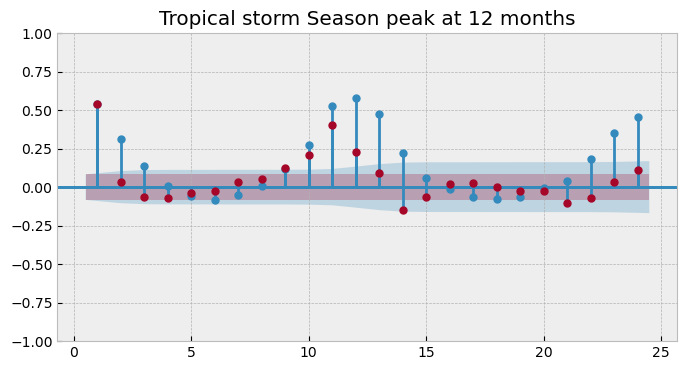

In [323]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(storms_qty_month['status_tropical storm'], ax=ax, lags=24, zero=False)
plt.title('Tropical storm Season peak at 12 months')

plot_pacf(storms_qty_month['status_tropical storm'], ax=ax, lags=24, zero=False)
plt.title('Tropical storm Season peak at 12 months')

plt.show()

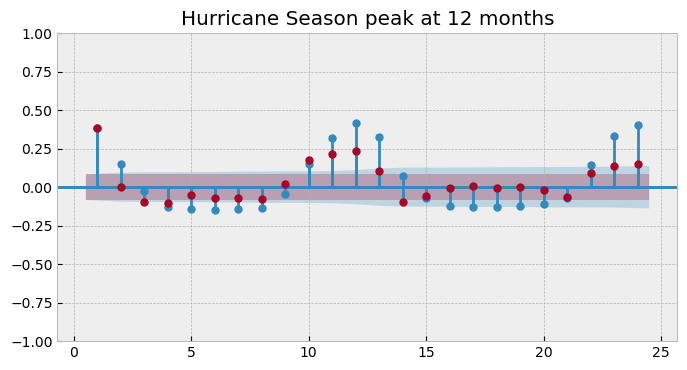

In [329]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(storms_qty_month['status_hurricane'], ax=ax, lags=24, zero=False)
plt.title('Tropical storm Season peak at 12 months')

plot_pacf(storms_qty_month['status_hurricane'], ax=ax, lags=24, zero=False)
plt.title('Hurricane Season peak at 12 months')

plt.show()

## Creating model to predict Tropical Depression - Using data since 1975 (all data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1718.926, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1999.308, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1578.142, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1383.066, Time=0.51 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1383.996, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1384.073, Time=1.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1385.345, Time=2.39 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1385.061, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1385.062, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1499.505, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1382.872, Time=0.82 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,2)(1,1,1)[12]          

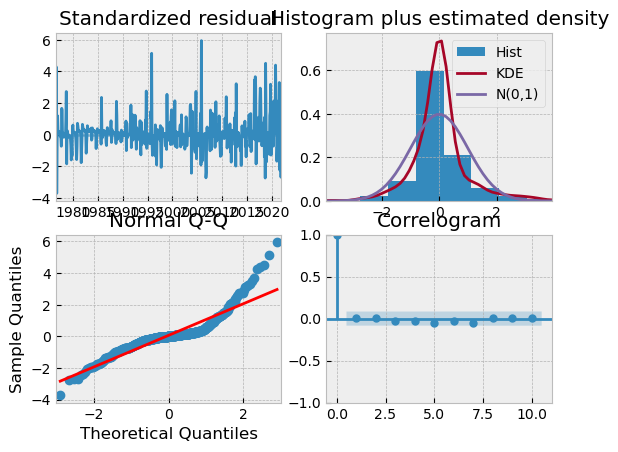

In [175]:

#tropical_depression_2011 = storms_qty_month.loc[storms_qty_month.index>'2011', 'status_tropical depression']

result_depression_m_alldata = pm.auto_arima(storms_qty_month_depression,
                          seasonal=True, m=12,
                          d=1, D=1, start_p=0, start_q=0, start_P=0, start_Q=1,
                          max_d=2, max_p=4, max_q=4,max_P=4, max_Q=4, 
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True
                            )

print(result_depression_m_alldata.summary())

result_depression_m_alldata.plot_diagnostics()

plt.show();

**The above plot diagnostics and scores shows that the best model is not generalizing well with all data provided.**

## Creating model to predict Tropical Depression - Using data since 2011

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=468.607, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=495.082, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=398.867, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=392.375, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=394.366, Time=0.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=394.365, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=397.651, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=396.369, Time=0.69 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=389.421, Time=0.16 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=404.382, Time=0.01 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=390.644, Time=0.25 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=390.657, Time=0.40 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=389.617, Time=0.09 sec
 ARIMA(1,1,1)(1,1,2)[12]             

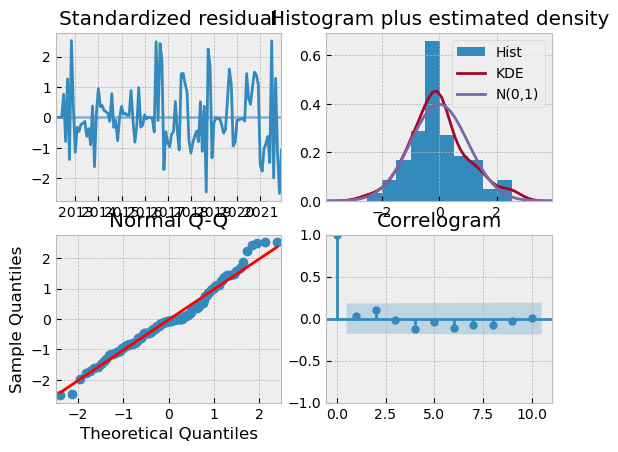

In [178]:

tropical_depression_2011 = storms_qty_month_depression[storms_qty_month_depression.index>'2011']

result_depression_m_2011 = pm.auto_arima(tropical_depression_2011,
                          seasonal=True, m=12,
                          d=1, D=1, start_p=0, start_q=0, start_P=0, start_Q=1,
                          max_d=2, max_p=4, max_q=4,max_P=4, max_Q=4, 
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True
                            )

print(result_depression_m_2011.summary())

result_depression_m_2011.plot_diagnostics()

plt.show();

**The above plot diagnostics shows a better generalization of the data when using data points from 2011 to 2021**

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=296.742, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=342.570, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=309.375, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=297.750, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=340.703, Time=0.01 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=297.768, Time=0.16 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=297.803, Time=0.36 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=308.117, Time=0.05 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=297.667, Time=0.11 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=299.484, Time=0.50 sec
 ARIMA(0,0,0)(0,1,1)[12]             : AIC=298.135, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,1,1)[12] intercept
Total fit time: 2.651 seconds
                                 SARIMAX Results                                  
Dep. Var

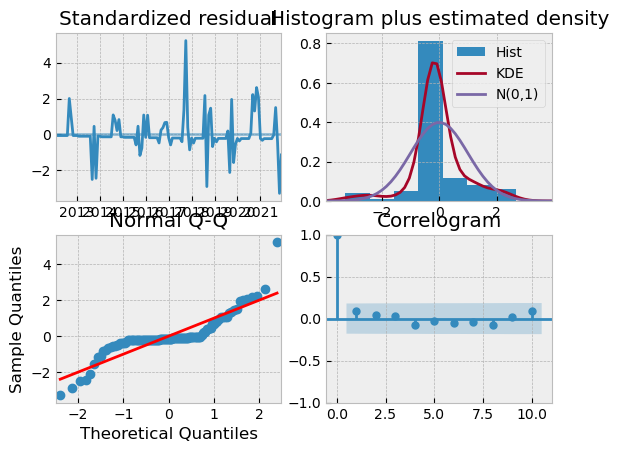

In [272]:

hurricane_2011 = storms_qty_month_hurricane[storms_qty_month_hurricane.index>'2011']

result_hurricane_m_2011 = pm.auto_arima(hurricane_2011,
                          seasonal=True, m=12,
                          d=0, D=1, start_p=0, start_q=0, start_P=0, start_Q=1,
                          max_d=2, max_p=4, max_q=4,max_P=4, max_Q=4, 
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True
                            )

print(result_hurricane_m_2011.summary())

result_hurricane_m_2011.plot_diagnostics()

plt.show();

## Applying seasonal decompose

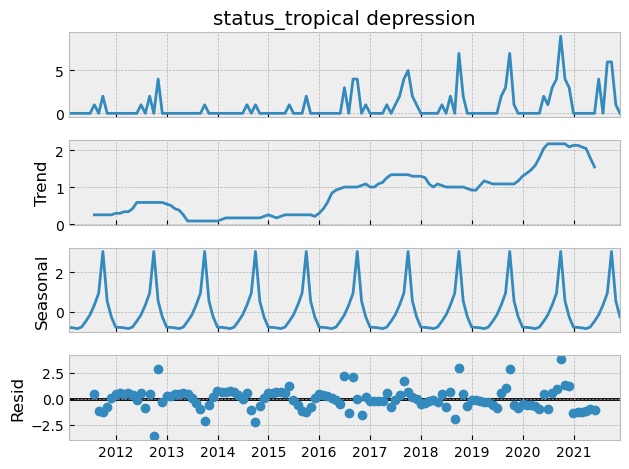

In [251]:
result_decompose_all = seasonal_decompose(storms_qty_month_depression[storms_qty_month_depression.index>'2011'],
                                          model='additive')
result_decompose_all.plot()
plt.show();


# Creating SARIMAX model for each timeserie 

## SARIMAX model for Tropical depression 

In [182]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create model object
model_s_depression = SARIMAX(tropical_depression_2011, 
                order=(1,1,2), 
                seasonal_order=(0,1,1,12), 
)

result_s_depression = model_s_depression.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45923D+00    |proj g|=  1.26402D-01

At iterate    5    f=  1.44826D+00    |proj g|=  4.39371D-03

At iterate   10    f=  1.44815D+00    |proj g|=  1.83946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   3.280D-06   1.448D+00
  F =   1.4481514656702428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


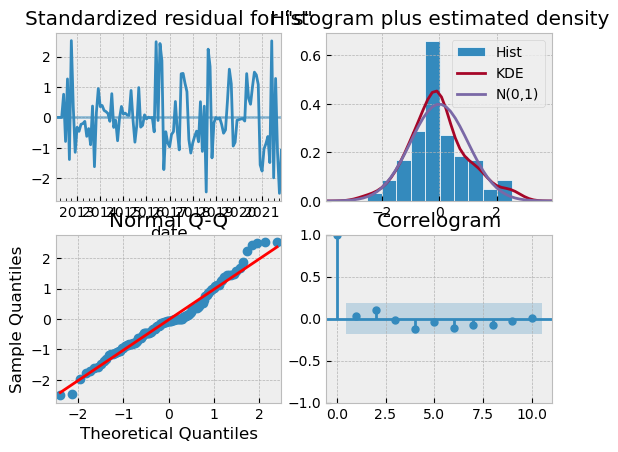

In [183]:
result_s_depression.plot_diagnostics();

### One-Hot-Step prediction for Tropical Depression (Within data)

In [185]:
prediction_s_depression = result_s_depression.get_prediction(start=-48)

mean_prediction_s_depression = prediction_s_depression.predicted_mean
#round(mean_forecast,0)

confidence_s_intervals = prediction_s_depression.conf_int()

lower_s_limits = confidence_s_intervals.loc[:,'lower status_tropical depression']
upper_s_limits = confidence_s_intervals.loc[:,'upper status_tropical depression']

In [186]:
plot_forecast_prediction_plotly(tropical_depression_2011, mean_prediction_s_depression,
                         lower_s_limits, upper_s_limits)

### Forecast for Tropical Depression (out-of-data)

In [188]:
depression_s_forecast_steps = result_s_depression.get_forecast(steps=24)

mean_forecast_s_depression = depression_s_forecast_steps.predicted_mean

mean_forecast_s_depression[mean_forecast_s_depression < 0] = 0

confidence_interval_fc_s_depression = depression_s_forecast_steps.conf_int()

lower_s_limits_forecast = confidence_interval_fc_s_depression.loc[:,'lower status_tropical depression']
upper_s_limits_forecast = confidence_interval_fc_s_depression.loc[:,'upper status_tropical depression']

lower_s_limits_forecast[lower_s_limits_forecast < 0] = 0

In [189]:
plot_forecast_prediction_plotly(tropical_depression_2011, mean_forecast_s_depression,
                         lower_s_limits_forecast, upper_s_limits_forecast)

## SARIMAX model for Tropical storm

In [191]:

tropical_storm_2011 = storms_qty_month_tropical[storms_qty_month_tropical.index>'2011']

# Create model object
model_s_storm = SARIMAX(tropical_storm_2011, 
                order=(1,1,2), 
                seasonal_order=(0,1,1,12), 
)

result_s_storm = model_s_storm.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49020D+00    |proj g|=  2.04400D-01

At iterate    5    f=  1.44228D+00    |proj g|=  7.73587D-03

At iterate   10    f=  1.44182D+00    |proj g|=  1.53916D-03


 This problem is unconstrained.



At iterate   15    f=  1.43336D+00    |proj g|=  1.58093D-02

At iterate   20    f=  1.43104D+00    |proj g|=  1.50850D-02

At iterate   25    f=  1.42902D+00    |proj g|=  4.71673D-03

At iterate   30    f=  1.42875D+00    |proj g|=  3.28826D-04

At iterate   35    f=  1.42873D+00    |proj g|=  4.63393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     49      1     0     0   1.992D-04   1.429D+00
  F =   1.4287274702581709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


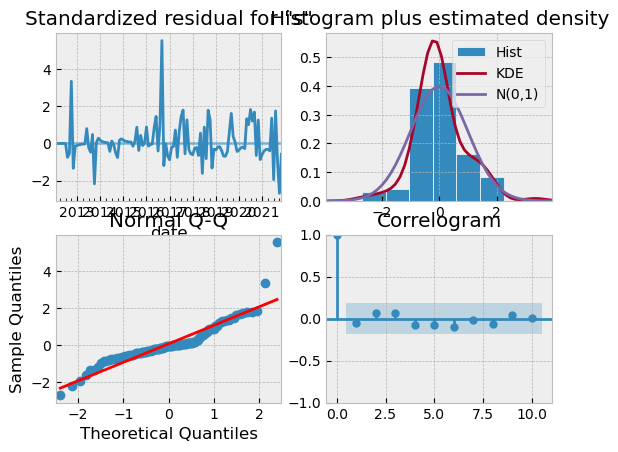

In [192]:
result_s_storm.plot_diagnostics();

### One-Hot-Step prediction for Tropical Storm (Within data)

In [194]:
prediction_s_storm = result_s_storm.get_prediction(start=-48)

mean_prediction_s_storm = prediction_s_storm.predicted_mean
#round(mean_forecast,0)

confidence_s_intervals_storm = prediction_s_storm.conf_int()

lower_s_limits_storm = confidence_s_intervals_storm.loc[:,'lower status_tropical storm']
upper_s_limits_storm = confidence_s_intervals_storm.loc[:,'upper status_tropical storm']

In [195]:
plot_forecast_prediction_plotly(tropical_storm_2011, mean_prediction_s_storm,
                         lower_s_limits_storm, upper_s_limits_storm)

### Forecast for Tropical Depression (out-of-data)

In [197]:
storm_s_forecast_steps = result_s_storm.get_forecast(steps=24)

mean_forecast_s_storm = storm_s_forecast_steps.predicted_mean

mean_forecast_s_storm[mean_forecast_s_storm < 0] = 0

confidence_interval_fc_s_storm = storm_s_forecast_steps.conf_int()

lower_s_limits_forecast_storm = confidence_interval_fc_s_storm.loc[:,'lower status_tropical storm']
upper_s_limits_forecast_storm = confidence_interval_fc_s_storm.loc[:,'upper status_tropical storm']

lower_s_limits_forecast_storm[lower_s_limits_forecast_storm < 0] = 0

In [198]:
plot_forecast_prediction_plotly(tropical_storm_2011, mean_forecast_s_storm,
                         lower_s_limits_forecast_storm, upper_s_limits_forecast_storm)

## SARIMAX model for Hurricane

In [274]:

hurricane_2011 = storms_qty_month_hurricane[storms_qty_month_hurricane.index>'2011']

# Create model object
model_s_hurricane = SARIMAX(hurricane_2011, 
                order=(0,0,0), 
                seasonal_order=(0,1,1,12), 
)

result_s_hurricane = model_s_hurricane.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14041D+00    |proj g|=  2.42821D-01

At iterate    5    f=  1.12283D+00    |proj g|=  1.01605D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   7.730D-07   1.123D+00
  F =   1.1226520364272541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


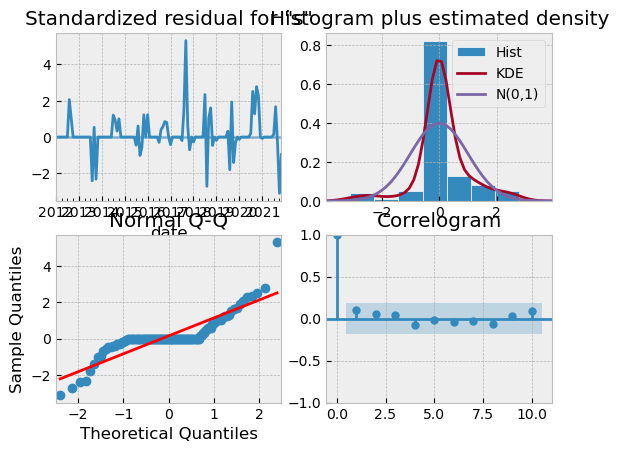

In [276]:
result_s_hurricane.plot_diagnostics();

### One-Hot-Step prediction for Hurricane (Within data)

In [278]:
prediction_s_hurricane = result_s_hurricane.get_prediction(start=-48)

mean_prediction_s_hurricane = prediction_s_hurricane.predicted_mean
#round(mean_forecast,0)

confidence_s_intervals_hurricane = prediction_s_hurricane.conf_int()

lower_s_limits_hurricane = confidence_s_intervals_hurricane.loc[:,'lower status_hurricane']
upper_s_limits_hurricane = confidence_s_intervals_hurricane.loc[:,'upper status_hurricane']

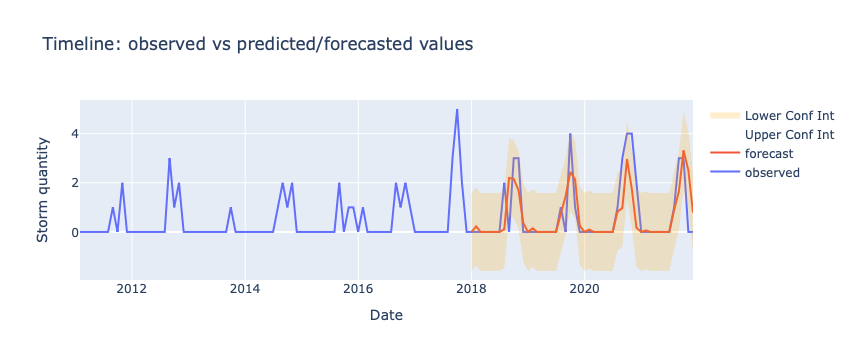

In [280]:
plot_forecast_prediction_plotly(hurricane_2011, mean_prediction_s_hurricane,
                         lower_s_limits_hurricane, upper_s_limits_hurricane)

### Forecast for Hurricane (out-of-data)

In [282]:
hurricane_s_forecast_steps = result_s_hurricane.get_forecast(steps=24)

mean_forecast_s_hurricane = hurricane_s_forecast_steps.predicted_mean

mean_forecast_s_hurricane[mean_forecast_s_hurricane < 0] = 0

confidence_interval_fc_s_hurricane = hurricane_s_forecast_steps.conf_int()

lower_s_limits_forecast_hurricane = confidence_interval_fc_s_hurricane.loc[:,'lower status_hurricane']
upper_s_limits_forecast_hurricane = confidence_interval_fc_s_hurricane.loc[:,'upper status_hurricane']

lower_s_limits_forecast_hurricane[lower_s_limits_forecast_hurricane < 0] = 0

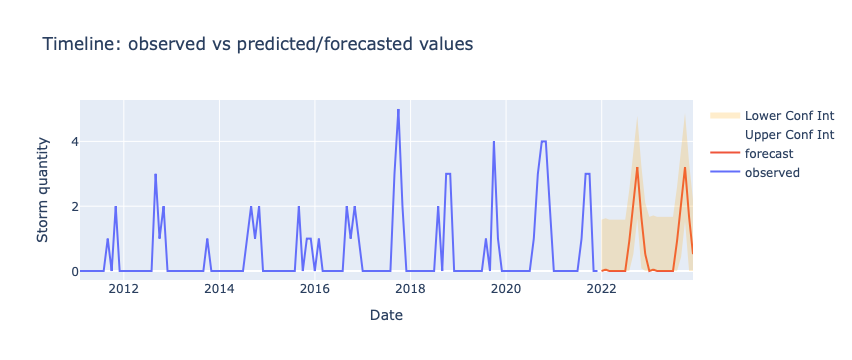

In [284]:
plot_forecast_prediction_plotly(hurricane_2011, mean_forecast_s_hurricane,
                         lower_s_limits_forecast_hurricane, upper_s_limits_forecast_hurricane)

# Result - Plotting all forecast together

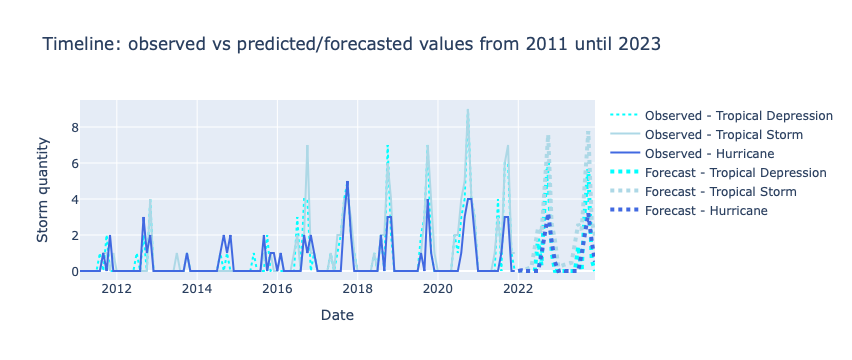

In [286]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tropical_depression_2011.index, y=tropical_depression_2011,
                    mode='lines',
                    name='Observed - Tropical Depression',
                    line=dict(color='cyan', width=2, dash='dot')))

fig.add_trace(go.Scatter(x=tropical_storm_2011.index, y=tropical_storm_2011,
                    mode='lines',
                    name='Observed - Tropical Storm',
                    line=dict(color='lightblue', width=2)))
    
fig.add_trace(go.Scatter(x=hurricane_2011.index, y=hurricane_2011,
                    mode='lines',
                    name='Observed - Hurricane',
                    line=dict(color='royalblue', width=2)))

fig.add_trace(go.Scatter(x=mean_forecast_s_depression.index, y=mean_forecast_s_depression,
                    mode='lines',
                    name='Forecast - Tropical Depression',
                    line=dict(color='cyan', width=4, dash='dot')))

fig.add_trace(go.Scatter(x=mean_forecast_s_storm.index, y=mean_forecast_s_storm,
                    mode='lines',
                    name='Forecast - Tropical Storm',
                    line=dict(color='lightblue', width=4, dash='dot')))
    
fig.add_trace(go.Scatter(x=mean_forecast_s_hurricane.index, y=mean_forecast_s_hurricane,
                    mode='lines',
                    name='Forecast - Hurricane',
                    line=dict(color='royalblue', width=4, dash='dot')))
    
fig.update_layout(title='Timeline: observed vs predicted/forecasted values from 2011 until 2023',
                   xaxis_title='Date',
                   yaxis_title='Storm quantity')
    
    
fig.show();

In [394]:
# Train-Test Split
train = storms_qty_month.loc[storms_qty_month.index>'2011','status_tropical depression'][:-12]
test = storms_qty_month.loc[storms_qty_month.index>'2011','status_tropical depression'][-12:]


In [444]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ETS Model
ets_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=12)
ets_result = ets_model.fit()
print(ets_result.summary())

                          ExponentialSmoothing Model Results                          
Dep. Variable:     status_tropical depression   No. Observations:                  119
Model:                   ExponentialSmoothing   SSE                            130.358
Optimized:                               True   AIC                             42.848
Trend:                               Additive   BIC                             87.314
Seasonal:                            Additive   AICC                            49.688
Seasonal Periods:                          12   Date:                 Mon, 05 Aug 2024
Box-Cox:                                False   Time:                         19:42:22
Box-Cox Coeff.:                          None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0601381              

In [446]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Forecasting
ets_forecast = ets_result.forecast(steps=12)
ets_rmse = np.sqrt(mean_squared_error(test, ets_forecast))
ets_mae = mean_absolute_error(test, ets_forecast)
ets_mape = mean_absolute_percentage_error(test, ets_forecast)
ets_aic = ets_result.aic
ets_bic = ets_result.bic

print(f'ETS RMSE: {ets_rmse}')
print(f'ETS MAE: {ets_mae}')
print(f'ETS MAPE: {ets_mape}')
print(f'ETS AIC: {ets_aic}')
print(f'ETS BIC: {ets_bic}')

ETS RMSE: 1.8920386445381705
ETS MAE: 1.7127924988368683
ETS MAPE: 4250229344114020.0
ETS AIC: 42.84781178384219
ETS BIC: 87.31378767362666


In [448]:
depression_s_forecast_steps_ets = ets_result.forecast(steps=36)

#depression_s_forecast_steps_ets[depression_s_forecast_steps_ets < 0] = 0


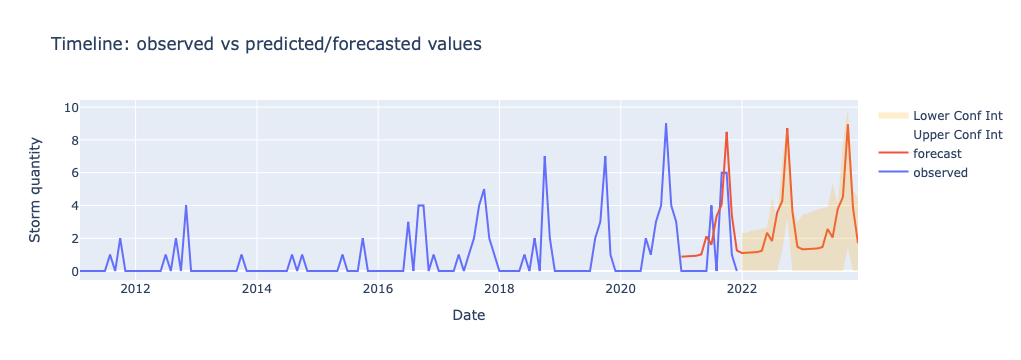

In [450]:
plot_forecast_prediction_plotly(tropical_depression_2011, depression_s_forecast_steps_ets,
                         lower_s_limits_forecast, upper_s_limits_forecast)

# Saving model

In [289]:
result_s_hurricane.save('../report/hurricane_model.pkl')
result_s_storm.save('../report/tropical_storm_model.pkl')
result_s_depression.save('../report/tropical_depression_model.pkl')
